<a href="https://colab.research.google.com/github/EVA6-Group-15/discover-architectures/blob/master/MNIST_99_4_Iteration_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git dlutils

fatal: destination path 'dlutils' already exists and is not an empty directory.


# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.86GB
Used: 571.54MB
Percentage: 6.5%


In [ ]:
! nvidia-smi

Thu Jun  3 18:04:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Targets

To create a basic skeleton of the the model

**Parameters**: Less than 10,000  
**Data Augmentations**: None  
**Regularization**: None  
**LR Scheduler**: None  
**No. of Epochs**: 14  


# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import dlutils.plotter as plotter
import dlutils.train as train
import dlutils.test as test

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [ ]:
plotter.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomRotation(7)]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

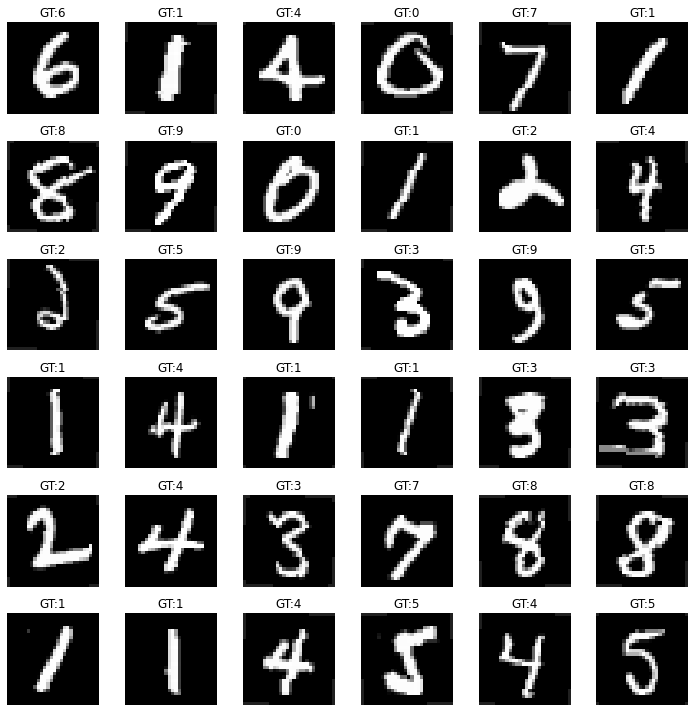

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plotter.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 28x28x1 -> 26x26x4
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=4),
            nn.ReLU(),
            nn.Dropout(0.043),
            # 26x26x4 -> 24x24x8
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Dropout(0.043),
            # 24x24x8 -> 12x12x8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 =  nn.Sequential(
            # 12x12x8 -> 10x10x16
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Dropout(0.043),
            # 10x10x16 -> 8x8x20
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=20),
            nn.ReLU(),
            nn.Dropout(0.043),
            # 8x8x20 -> 6x6x24
            nn.Conv2d(in_channels=20, out_channels=24, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=24),
            nn.ReLU(),
            nn.Dropout(0.043),
            # 6x6x24 -> 6x6x10
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=1, bias=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.gap(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
           Dropout-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             288
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 12, 12]           1,152
      BatchNorm2d-11           [-1, 16, 12, 12]              32
             ReLU-12           [-1, 16, 12, 12]               0
          Dropout-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1, 20,

# Training

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer = train.Train(model, device, train_loader, optimizer)
tester = test.Test(model, device, test_loader)

for epoch in range(1, 15):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer()
    scheduler.step()
    test_loss, test_acc = tester()

    print('Train: Average loss: {:.4f}, Train Accuracy: {:.2f}%; Test: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(train_loss, train_acc, test_loss, test_acc))

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.14986750483512878 batch_id=937: 100%|██████████| 938/938 [00:32<00:00, 28.47it/s]


Train: Average loss: 0.2363, Train Accuracy: 92.67%; Test: Average loss: 0.0879, Test Accuracy: 97.26%
Epoch: 2
Train: Average loss: 0.0791, Train Accuracy: 97.46%; Test: Average loss: 0.0527, Test Accuracy: 98.28%
Epoch: 3
Train: Average loss: 0.0645, Train Accuracy: 97.96%; Test: Average loss: 0.0325, Test Accuracy: 98.98%
Epoch: 4
Train: Average loss: 0.0555, Train Accuracy: 98.19%; Test: Average loss: 0.0378, Test Accuracy: 98.75%
Epoch: 5
Train: Average loss: 0.0512, Train Accuracy: 98.36%; Test: Average loss: 0.0303, Test Accuracy: 99.08%
Epoch: 6
Train: Average loss: 0.0466, Train Accuracy: 98.52%; Test: Average loss: 0.0269, Test Accuracy: 99.13%
Epoch: 7
Train: Average loss: 0.0343, Train Accuracy: 98.92%; Test: Average loss: 0.0194, Test Accuracy: 99.39%
Epoch: 8
Train: Average loss: 0.0306, Train Accuracy: 99.03%; Test: Average loss: 0.0190, Test Accuracy: 99.37%
Epoch: 9
Train: Average loss: 0.0291, Train Accuracy: 99.06%; Test: Average loss: 0.0181, Test Accuracy: 99.42%
E

# Results

In [ ]:
print('Train Accuracy:', max(trainer.accuracy))
print('Test Accuracy:', max(tester.accuracy))

Train Accuracy: 99.125
Test Accuracy: 99.47


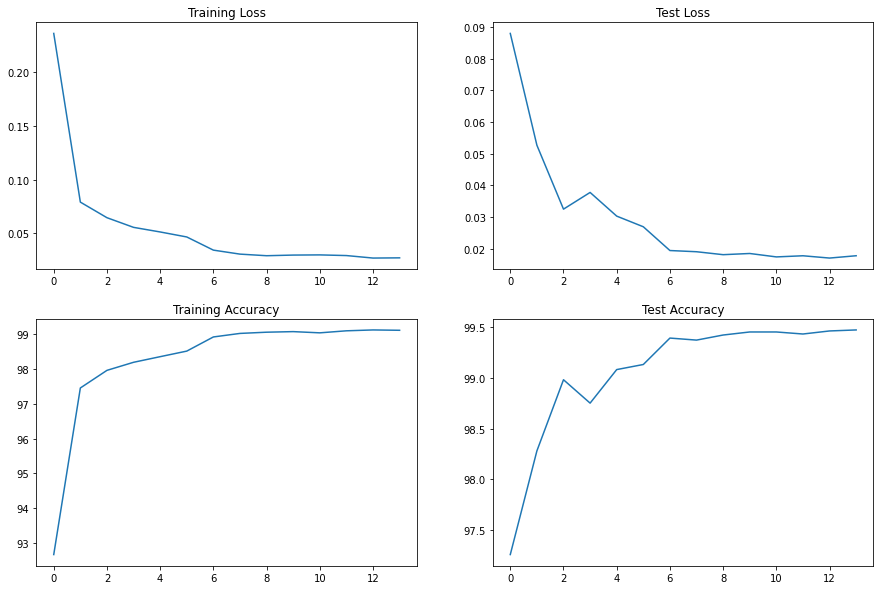

In [ ]:
plotter.plot_loss_acc(trainer.loss, trainer.accuracy, tester.loss, tester.accuracy)

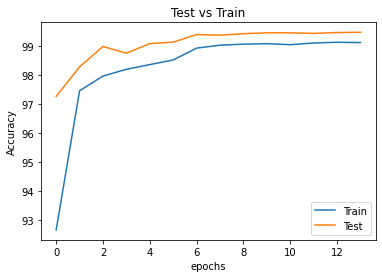

In [ ]:
plotter.plot_combined(trainer.accuracy, tester.accuracy,  x_label='epochs', y_label='Accuracy')

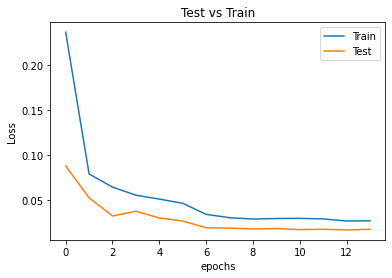

In [ ]:
plotter.plot_combined(trainer.loss, tester.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results = plotter.Results(model, test_loader, device, mean, std, class_list)

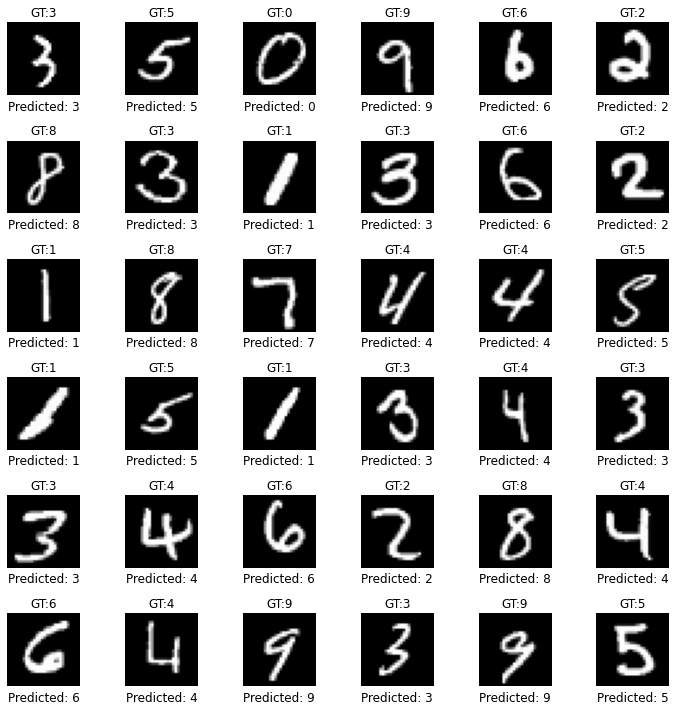

In [ ]:
results.plot_batch(6,6)

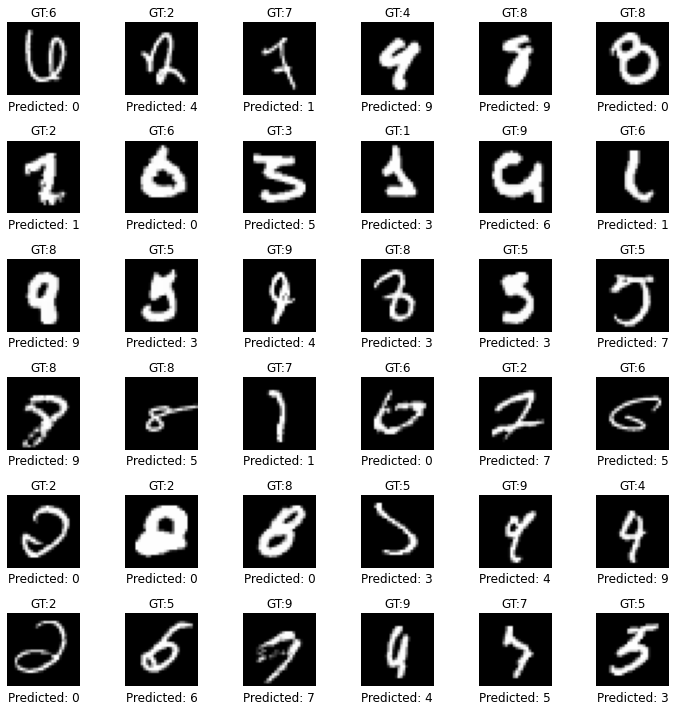

In [ ]:
results.plot_incorrect()

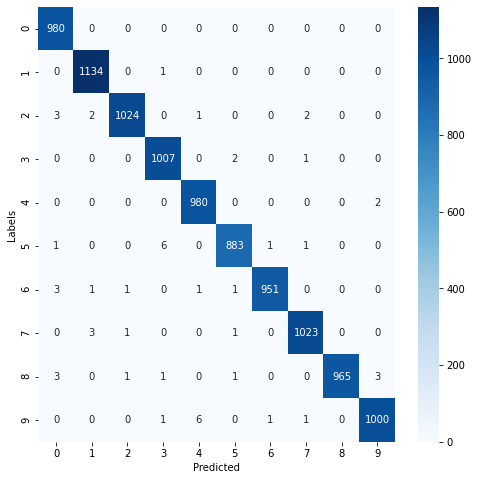

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 5 is 98.99
Accuracy of class 8 is 99.08
Accuracy of class 9 is 99.11
Accuracy of class 2 is 99.22
Accuracy of class 6 is 99.27
Accuracy of class 7 is 99.51
Accuracy of class 3 is 99.70
Accuracy of class 4 is 99.80
Accuracy of class 1 is 99.91
Accuracy of class 0 is 100.00


In [ ]:
results.class_accuracy()

# Model Architecture

In [ ]:
!pip3 install hiddenlayer

In [ ]:
import hiddenlayer as hl
model = Net().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


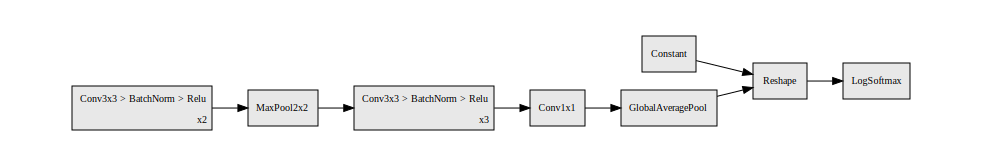

In [ ]:
network_graph

# Achievements

- Total Parameters used: **9,060**
- Best Train Accuracy: **99.12%**
- Best Test Accuracy: **99.47%**
- Consistency: Accuracy greater than 99.4 consistent from 9th epoch to 14th epoch
- Data Augmentation: Random Rotation of 7 degrees.
- Learning Rate Scheduler: StepLR used

# Analysis

The StepLR helped in stabilizing the learning, by reducing the learning rate to 10% after every 6th Epochs.

Why after every 6 epochs?
We observed that the Loss was bouncing up and down, from 6th/7th epoch, so reducing the LR at that point would made the training stable.

The Random Rotation was applied with ±7 degrees.